In [1]:
from common.const import FILEPATH
from common.utils import describe_dataframe_details, rename_columns

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/21 00:17:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv(FILEPATH.RAW, header=True, inferSchema =True)

In [4]:
df.show()

+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+-------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+--------------+
|  Body Type|   Sex|       Diet|How Often Shower|Heating Energy Source|   Transport|Vehicle Type|Social Activity|Monthly Grocery Bill|Frequency of Traveling by Air|Vehicle Monthly Distance Km|Waste Bag Size|Waste Bag Weekly Count|How Long TV PC Daily Hour|How Many New Clothes Monthly|How Long Internet Daily Hour|Energy efficiency|           Recycling|        Cooking_With|CarbonEmission|
+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+-------------

In [5]:
df.printSchema()

root
 |-- Body Type: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Diet: string (nullable = true)
 |-- How Often Shower: string (nullable = true)
 |-- Heating Energy Source: string (nullable = true)
 |-- Transport: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Social Activity: string (nullable = true)
 |-- Monthly Grocery Bill: integer (nullable = true)
 |-- Frequency of Traveling by Air: string (nullable = true)
 |-- Vehicle Monthly Distance Km: integer (nullable = true)
 |-- Waste Bag Size: string (nullable = true)
 |-- Waste Bag Weekly Count: integer (nullable = true)
 |-- How Long TV PC Daily Hour: integer (nullable = true)
 |-- How Many New Clothes Monthly: integer (nullable = true)
 |-- How Long Internet Daily Hour: integer (nullable = true)
 |-- Energy efficiency: string (nullable = true)
 |-- Recycling: string (nullable = true)
 |-- Cooking_With: string (nullable = true)
 |-- CarbonEmission: integer (nullable = true)



In [6]:
info_table = describe_dataframe_details(spark=spark, df=df)
info_table

summary,count,mean,stddev,min,max,outlier_count,null_count
Body Type,10100,None,None,fat,very fat,None,100
Sex,10200,None,None,f,male,None,0
Diet,10196,None,None,omnivore,vegetarian,None,4
How Often Shower,10187,None,None,daily,twice a day,None,13
Heating Energy Source,10200,None,None,coal,wood,None,0
Transport,10189,None,None,private,walk/bicycle,None,11
Vehicle Type,3344,None,None,diesel,petrol,None,6856
Social Activity,10195,None,None,never,sometimes,None,5
Monthly Grocery Bill,10200,176.39098039215688,140.2894374654016,1,8000,6,0
Frequency of Traveling by Air,10200,None,None,frequently,very frequently,None,0


In [7]:
df = rename_columns(df=df)

In [15]:
# Drop all Null value from pyspark dataframe
df = df.na.drop()

In [27]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum

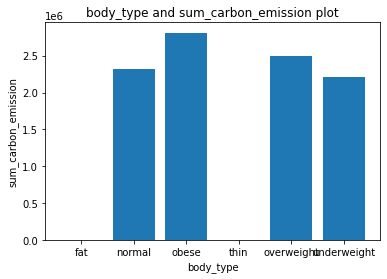

In [28]:


# Calculate the sum of carbon_emission for each body_type
df_grouped = df.groupBy('body_type').agg(sum('carbon_emission').alias('sum_carbon_emission'))

# Create a DataFrame with distinct body_type values and their corresponding sum of carbon_emission
df_distinct = df_grouped.select('body_type').distinct() \
    .join(df_grouped, on='body_type', how='left') \
    .na.fill(0)

# Plot the results
import matplotlib.pyplot as plt

x_values = df_distinct.select('body_type').rdd.flatMap(lambda x: x).collect()
y_values = df_distinct.select('sum_carbon_emission').rdd.flatMap(lambda x: x).collect()

plt.bar(x_values, y_values)
plt.ylabel('sum_carbon_emission')
plt.xlabel('body_type')
plt.title('body_type and sum_carbon_emission plot')
plt.show()